In [58]:
from fastai.imports import *
from fastai.vision.all import *
import os


# Analysing clustering, dimensionality reduction and feature extraction techniques with labeled data

in this notebook we use a subset of the [Food-101 dataset](https://www.kaggle.com/datasets/kmader/food41) and the [House Rooms & Streets Image Dataset](https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset)

first look at some sample images from our datasets

In [59]:
food_path=Path("tripadvisor_dataset/kaggle/archive (1)/images")
building_path=Path("tripadvisor_dataset/kaggle/archive/kaggle_room_street_data")

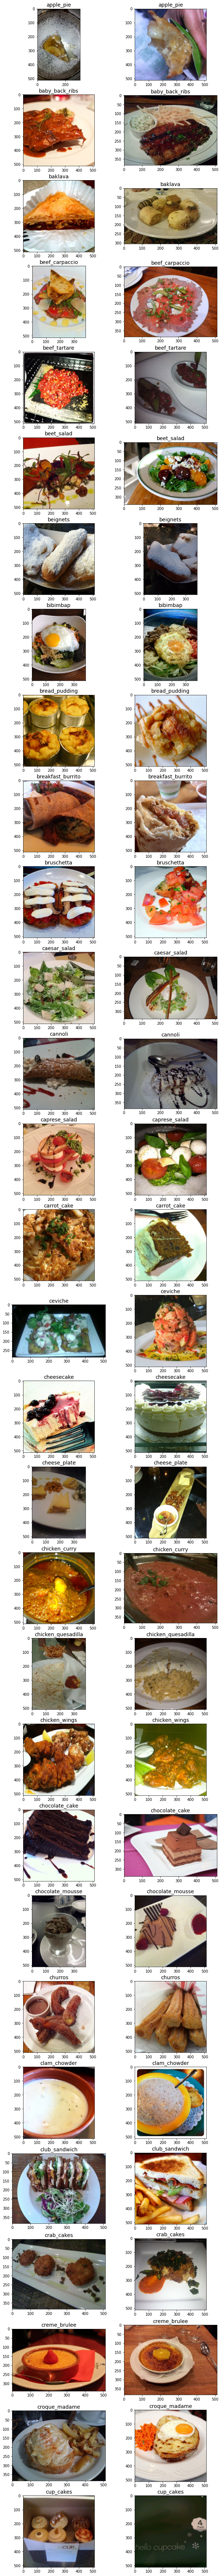

In [60]:
fig, ax = plt.subplots(figsize=(10,128),nrows=30, ncols=2, ) #make a figure to plot
for i,category in enumerate(os.listdir(food_path)): #loop over image categories
    for j, img in enumerate(os.listdir(os.path.join(food_path,category))): # loop over images in each category
        ax[i,j].imshow(PILImage.create(os.path.join(food_path,category,img)),label=category) #plot image
        ax[i,j].set_title(category,fontsize = 14)
        if(j==1):break
    if i==29:break

these were some food images, now let's look at some non-food images

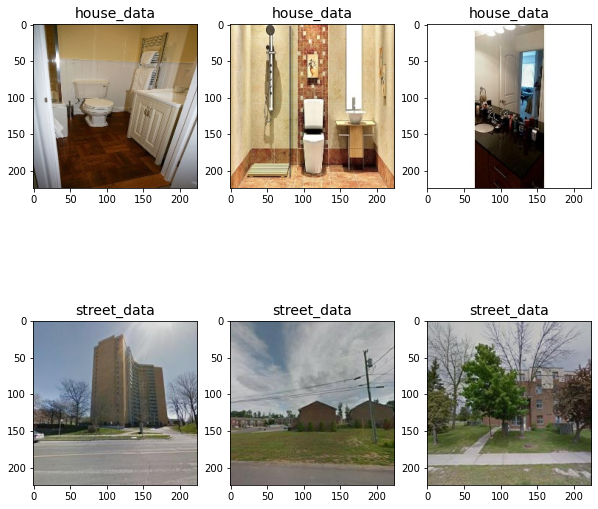

In [61]:
fig, ax = plt.subplots(figsize=(10,10),nrows=2, ncols=3, ) #make a figure to plot
for i,category in enumerate(os.listdir(building_path)): #loop over street data categories
    for j, img in enumerate(os.listdir(os.path.join(building_path,category))): # loop over images in each category
        ax[i,j].imshow(PILImage.create(os.path.join(building_path,category,img)),label=category) #plot image
        ax[i,j].set_title(category,fontsize = 14)
        if(j==2):break


we will make our custom dataset based on the street and food data

In [62]:
num_food_class=len(os.listdir(food_path))
print(f"there are {num_food_class} food classes" )
print(f"there are 2 non-food classes" )

there are 101 food classes
there are 2 non-food classes


we will make a dataset consisting of 505 food images (5 images from each class) and 500 non-food images

In [63]:
# Resizing to this sizes
IMG_HEIGHT = 128
IMG_WIDTH = 128

def create_dataset():
    # n = amount of images
    n=1005
    counter=0
    images = np.zeros((n, IMG_HEIGHT* IMG_WIDTH* 3))
    
    for i,category in enumerate(os.listdir(food_path)): #loop over image food categories
        for j, img in enumerate(os.listdir(os.path.join(food_path,category))[:5]): # loop over first 5 images in each category
            img=PILImage.create(os.path.join(food_path,category,img))#plot image
            img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
            img_np=np.array(img_resized).flatten()
            images[counter]=img_np/255
            counter+=1
    
    
    for i,category in enumerate(os.listdir(building_path)): #loop over street data categories
        for j, img in enumerate(os.listdir(os.path.join(building_path,category))[:250]): # loop over first 250 images in each category       
            img=PILImage.create(os.path.join(building_path,category,img))
            img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
            img_np=np.array(img_resized).flatten()
            images[counter]=img_np/255
            counter+=1    
    return images
    
    



In [64]:
images = create_dataset()

## SIFT
After reading the images, extract the features with **SIFT**.

In [65]:
import cv2

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    features = []
    sift = cv2.xfeatures2d.SIFT_create()
    for img in images:
        img = img.reshape(IMG_HEIGHT,IMG_WIDTH,3)
        # SIFT function only accepts images with 8 bit integer values
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        # Convert the training image to gray scale
        training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


        keypoints, descriptor = sift.detectAndCompute(training_gray, None)
        descriptor_list.extend(descriptor)
        features.append(keypoints)


    return (descriptor_list, np.array(features))


descriptors, features = sift_features(images)


C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\2264410521.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (descriptor_list, np.array(features))


In [66]:
descriptors[0].shape # descriptors is a list

(128,)

We now have an array with a huge number of descriptors. We cannot use all of them to create the model, so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10.

In [67]:
from sklearn.cluster import KMeans

number_of_categories = 10

def kmeans(descriptor_list):
    k = number_of_categories * 10
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

visual_words = kmeans(descriptors)
visual_words

array([[ 71.24964539,  20.76879433,  11.18297872, ...,   9.49007092,
          8.96028369,  15.97446809],
       [ 20.51519435,  18.06431095,  19.02473498, ...,   8.88409894,
          6.8869258 ,  14.40424028],
       [ 15.7059322 ,  70.35      , 100.97627119, ...,   7.9720339 ,
          7.28389831,  10.41525424],
       ...,
       [ 12.64892183,   9.82681941,  11.52425876, ...,   5.57614555,
          5.33760108,  13.54447439],
       [  8.88809311,   4.14413608,   8.92479857, ...,   9.65443151,
         11.22739481,  15.81289167],
       [ 13.9407314 ,   7.35372005,   7.56998739, ...,   4.86885246,
          4.96343001,  10.75851198]])

### Making histograms


In [68]:
# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
from scipy.spatial import distance

def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [69]:
def image_class(features, centers, descriptors):
    begin = 0
    histogrammen = []
    for f in features:
        histogram = np.zeros(len(centers))
        for i in range(begin, begin + len(f)):
            ind = find_index(descriptors[i], centers)
            histogram[ind] += 1
        histogrammen.append(histogram)
        begin += len(f)

    return histogrammen


image_features = image_class(features, visual_words, descriptors)

In [70]:
print(len(image_features)) # amount of images
image_features[0].shape # amount of centroids


1005


(100,)

In [71]:
images.shape
##eerste 505 afbeeldingen zijn voedsel, laatste 500 zijn niet voedsel


(1005, 49152)

first attempt making a score function for our kmeans

In [72]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
raw_scaled = sc.fit_transform(images)

kmeans = KMeans(n_clusters=5, random_state=0)
pred=kmeans.fit_predict(raw_scaled)

In [73]:
pred

array([0, 0, 0, ..., 2, 2, 1])

Ideally, we'd like some way to try more clusters ans test our performance easily . We could create a function that returns how good our model is, in order to more quickly try out a few different methods. We'll create a score function to do this. Instead of returning the mean absolute error, we'll calculate a measure of impurity -- that is, how much our model creates clusters where the images in a group are each similar to each other, or dissimilar.

In [74]:
num_clusters=np.unique(pred)##will be the amount of clusters

we will explain this step by step for cluster 0

In [75]:
image_idx=np.where(pred == 0)#indexes of images in this cluster
image_idx

(array([   0,    1,    2,   11,   12,   16,   18,   20,   23,   27,   29,
          39,   42,   44,   46,   49,   55,   56,   57,   58,   62,   64,
          66,   68,   74,   76,   77,   78,   93,   95,   96,   97,   99,
         101,  105,  106,  111,  114,  117,  119,  120,  123,  124,  125,
         126,  131,  139,  143,  147,  151,  152,  155,  161,  163,  166,
         171,  173,  174,  175,  176,  178,  182,  183,  189,  192,  197,
         198,  199,  200,  201,  203,  204,  205,  206,  207,  208,  213,
         217,  218,  219,  224,  226,  227,  230,  231,  232,  234,  239,
         242,  244,  246,  247,  250,  252,  254,  256,  257,  260,  266,
         270,  272,  279,  286,  287,  290,  295,  304,  307,  309,  311,
         313,  314,  318,  334,  337,  338,  339,  342,  345,  351,  355,
         361,  362,  364,  365,  369,  370,  376,  377,  379,  382,  390,
         396,  398,  408,  410,  416,  420,  422,  425,  426,  427,  431,
         432,  433,  448,  453,  456, 

In [76]:
binary=image_idx[0]<505 #image indexes smaller than 505 are food
binary

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

calculate the impurity of our cluster with the standard deviation

We can measure the similarity of images inside a group by taking the standard deviation of the dependent variable. If it's higher, then it means the images are more different to each other. We'll then multiply this by the number of images in the cluster, since a bigger cluster as more impact than a smaller one:

now putting it all together

In [78]:
#for each cluster calculate the std

def cluster_score(pred):
    score=0
    num_clusters=np.unique(pred)
    for clusternr in num_clusters:
        image_idx=np.where(pred == clusternr)#indexes of images in this cluster
        binary=image_idx[0]<505
        tot=binary.size
        score+=(binary.std()*tot)
    return score/len(pred) #score averaged out over the number of clusters

def calculate_score(pred):
    num_clusters = np.unique(pred)##will be the amount of clusters
    image_idx = np.where(pred == 0)#indexes of images in this cluster
    binary = image_idx[0]<505 #image indexes smaller than 505 are food
    return cluster_score(pred)

In [79]:
cluster_score(pred) #higher is bad

0.43483453617853285

Now we try the kmeans on the SIFT features

In [80]:
kmeans = KMeans(n_clusters=5, random_state=0)
pred=kmeans.fit_predict(image_features)
sift_kmeans = calculate_score(pred)
sift_kmeans

0.4599498167538595

The score is lower (which means better). The reason because of this is probably because when you flatten raw data like raw_scaled you lose important spacial information. SIFT captures all the important features. From now we fit using the SIFT features because it gives better results.

## HOG

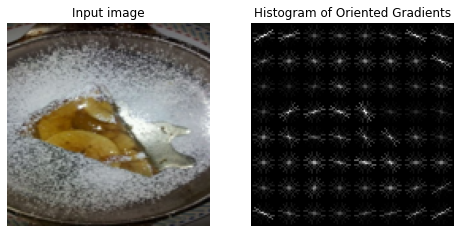

In [81]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

This is what we get from 1 picture, now let's apply it to our whole dataset

In [82]:
from tqdm import tqdm
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 1005/1005 [00:09<00:00, 102.54it/s]


We start with standardizing our data

In [83]:
from sklearn.preprocessing import StandardScaler
# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

Now we cluster based on the hog images and compare the results to the raw data and SIFT.

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
predictions = kmeans.fit_predict(hogs_scaled)
calculate_score(predictions)

0.243215235096188

HOG is working better, that's not what we expected. We only tried it on kmeans though, we try some other cluster algorithms to see if HOG is still better. At the end of the notebook there will be a dictionary with all the scores of the cluster algorithms we tried on HOG and SIFT.

In [85]:
results_hog = {}
results_sift = {}

results_hog["kmeans"] = calculate_score(predictions)
results_sift["kmeans"] = sift_kmeans

## Optimizing cluster algorithms - SIFT
We try now different cluster algorithms to see if some can do better than kmeans. We take 5 clusters as example. We try first on SIFT.

In [110]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
pred = dbscan.fit_predict(image_features)
results_sift["dbscan"] = calculate_score(pred)
calculate_score(pred)

0.4999938119960642

In [111]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=5)
pred = hier.fit_predict(image_features)
results_sift["aggcluster"] = calculate_score(pred)
calculate_score(pred)

0.46526835856761667

In [112]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=5)
pred = birch.fit_predict(image_features)
results_sift["birch"] = calculate_score(pred)
calculate_score(pred)

0.47564126124765604

Now we do a randomsearch to see if we can optimize the score.

First we do a randomsearch on AgglomerativeClustering, we don't use the standard parameters in our params. The reason for this is because not all parameter combinations are possible, some are not possible as defined in the api.

We don't vary the parameter n_clusters because our scoring method will always perform better when the amount of clusters is high (for example 1000 clusters will give a score of almost 0). Our scoring function is not a good predictor for choosing the amount of clusters (you can compare this with inertia).

In [113]:
from sklearn.model_selection import RandomizedSearchCV

def new_cluster_score(pred, x_test):
    return -cluster_score(pred)

params = {"n_clusters": [5], "affinity": ["l1", "l2", "manhattan", "cosine"], "linkage": ["complete", "average", "single"]}

hier = AgglomerativeClustering()

In [114]:
random_search = RandomizedSearchCV(hier, params, scoring=new_cluster_score)
search = random_search.fit(image_features)
print(search.best_params_)

c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\1556883925.py", line 4, in new_cluster_score
    return -cluster_score(pred)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\3315538182.py", line 11, in cluster_score
    return score/len(pred) #score averaged out over the number of clusters
TypeError: object of type 'AgglomerativeClustering' has no len()

  warnings.warn(
c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score

{'n_clusters': 5, 'linkage': 'complete', 'affinity': 'l1'}


Now we see what score these parameters give us, hopefully it's better than our original parameters

In [115]:
a = AgglomerativeClustering(n_clusters=5, linkage="complete", affinity="l2")
pred = a.fit_predict(image_features)
results_sift["agg_random_search"] = calculate_score(pred)
calculate_score(pred)

0.4878023695357963

That didn't improve our results sadly, the default parameters were better. We also check how much elements there are in each cluster and that doesn't look great, we'll definitely not use these parameters

In [116]:
unique, counts = np.unique(pred, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 978]
 [  1  22]
 [  2   3]
 [  3   1]
 [  4   1]]


We try now a randomsearch on birch.

In [117]:
params = {"n_clusters": [5], "threshold": np.arange(0.1, 1, 0.1)}
birch = Birch()

random_search = RandomizedSearchCV(birch, params, scoring=new_cluster_score)
search = random_search.fit(image_features)
print(search.best_params_)

c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\1556883925.py", line 4, in new_cluster_score
    return -cluster_score(pred)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\3315538182.py", line 11, in cluster_score
    return score/len(pred) #score averaged out

{'threshold': 0.1, 'n_clusters': 5}


Now we see what score these parameters give us, hopefully it's better than our original parameters

In [118]:
birch = Birch(n_clusters=5, threshold=0.1)
pred = birch.fit_predict(image_features)
results_sift["birch_random_search"] = calculate_score(pred)
calculate_score(pred)

0.47564126124765604

The score is the same as before, the threshold doesn't matter in our case.

## Optimizing cluster algorithms - HOG
We try now different cluster algorithms to see if some can do better than kmeans. We take 5 clusters as example. We try now on HOG.

In [119]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
pred = dbscan.fit_predict(hogs_scaled)
results_hog["dbscan"] = calculate_score(pred)
calculate_score(pred)

0.4999938119960642

In [120]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=5)
pred = hier.fit_predict(hogs_scaled)
results_hog["agg_cluster"] = calculate_score(pred)
calculate_score(pred)

0.24807911615286943

In [121]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=5)
pred = birch.fit_predict(hogs_scaled)
results_hog["birch"] = calculate_score(pred)
calculate_score(pred)

0.24807911615286943

We will do now a random search

In [122]:
params = {"n_clusters": [5], "affinity": ["l1", "l2", "manhattan", "cosine"], "linkage": ["complete", "average", "single"]}

hier = AgglomerativeClustering()

random_search = RandomizedSearchCV(hier, params, scoring=new_cluster_score)
search = random_search.fit(hogs_scaled)
print(search.best_params_)


c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\1556883925.py", line 4, in new_cluster_score
    return -cluster_score(pred)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\3315538182.py", line 11, in cluster_score
    return score/len(pred) #score averaged out over the number of clusters
TypeError: object of type 'AgglomerativeClustering' has no len()

  warnings.warn(
c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score

{'n_clusters': 5, 'linkage': 'average', 'affinity': 'manhattan'}


Now we see what score these parameters give us, hopefully it's better than our original parameters

In [123]:
a = AgglomerativeClustering(n_clusters=5, linkage="complete", affinity="l1")
pred = a.fit_predict(hogs_scaled)
results_hog["agg_random_search"] = calculate_score(pred)
calculate_score(pred)

0.44528551261583943

We try now a randomsearch on birch.

In [124]:
params = {"n_clusters": [5], "threshold": np.arange(0.1, 1, 0.1)}
birch = Birch()

random_search = RandomizedSearchCV(birch, params, scoring=new_cluster_score)
search = random_search.fit(hogs_scaled)
print(search.best_params_)

c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hikma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\1556883925.py", line 4, in new_cluster_score
    return -cluster_score(pred)
  File "C:\Users\hikma\AppData\Local\Temp\ipykernel_17040\3315538182.py", line 11, in cluster_score
    return score/len(pred) #score averaged out

{'threshold': 0.1, 'n_clusters': 5}


Now we see what score these parameters give us, hopefully it's better than our original parameters

In [125]:
birch = Birch(n_clusters=5, threshold=0.1)
pred = birch.fit_predict(image_features)
results_hog["dbscan"] = calculate_score(pred)
calculate_score(pred)

0.47564126124765604

The score is the same as before, the threshold doesn't matter in our case.

## Conclusion

We take a look again at the results.

In [127]:
results_sift

{'kmeans': 0.4599498167538595,
 'dbscan': 0.4999938119960642,
 'aggcluster': 0.46526835856761667,
 'birch': 0.47564126124765604,
 'agg_random_search': 0.4878023695357963,
 'birch_random_search': 0.47564126124765604}

In [128]:
results_hog

{'kmeans': 0.243215235096188,
 'dbscan': 0.47564126124765604,
 'agg_cluster': 0.24807911615286943,
 'birch': 0.24807911615286943,
 'agg_random_search': 0.44528551261583943}

We see that the best cluster algorithm are agglomerative clustering and birch. The best feature extraction is HOG, what we didn't expect. It was unexpected because in the lab HOG didn't perform very well, so we thought it couldn't get any worse. Apparently, it can. 

We will apply HOG and birch on our ideas on the tripadivsor dataset.